In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data = np.genfromtxt('./dados_tratados.csv', delimiter=',')

In [3]:
X = data[:, :-1]  
y = data[:, -1]

X_treino_full, X_teste_final, y_treino_full, y_teste_final = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
param_grid_dt = {
    'dt__max_depth': [None, 5, 10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline_grid_dt = Pipeline([
    ('sampler', RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

grid_search_dt = GridSearchCV(
    estimator=pipeline_grid_dt,
    param_grid=param_grid_dt,
    cv=cv_strategy,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
)

print("Starting Grid Search for best Decision Tree parameters...")
grid_search_dt.fit(X_treino_full, y_treino_full)

print("\n--- Grid Search Results ---")
print(f"Best parameters found: {grid_search_dt.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_dt.best_score_:.4f}")

Starting Grid Search for best Decision Tree parameters...

--- Grid Search Results ---
Best parameters found: {'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best cross-validation F1-score: 0.8354



F1-score on the final test set: 0.8000


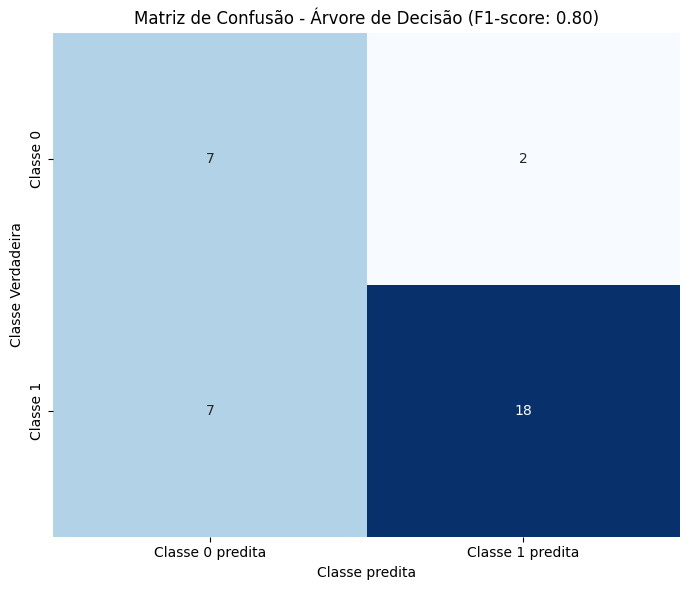

In [10]:
final_pipeline_dt = grid_search_dt.best_estimator_

y_pred_final_dt = final_pipeline_dt.predict(X_teste_final)

f1_final_test_dt = f1_score(y_teste_final, y_pred_final_dt)
print(f"\nF1-score on the final test set: {f1_final_test_dt:.4f}")

cm_dt = confusion_matrix(y_teste_final, y_pred_final_dt)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0 predita', 'Classe 1 predita'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Classe predita')
plt.ylabel('Classe Verdadeira')
plt.title(f'Matriz de Confusão - Árvore de Decisão (F1-score: {f1_final_test_dt:.2f})')
plt.tight_layout()
plt.show()

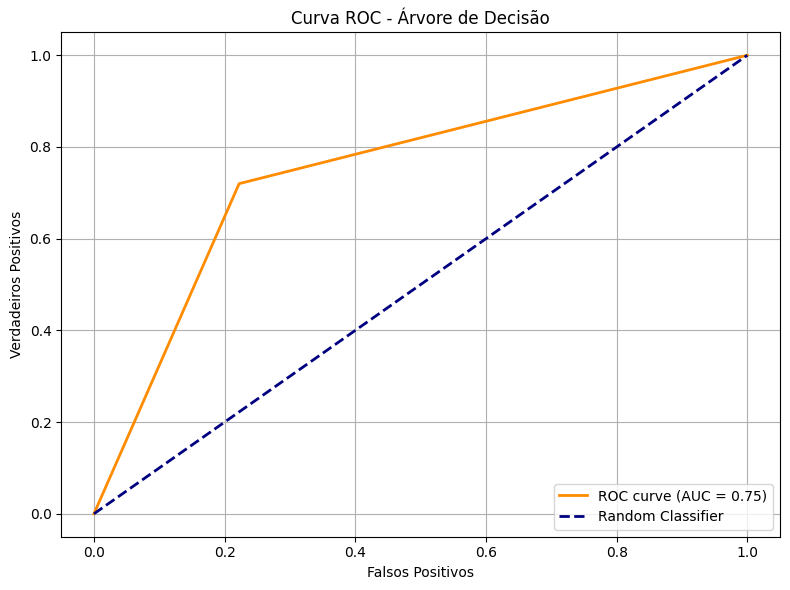

In [7]:
probas_final_dt = final_pipeline_dt.predict_proba(X_teste_final)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_teste_final, probas_final_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Curva ROC - Árvore de Decisão')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

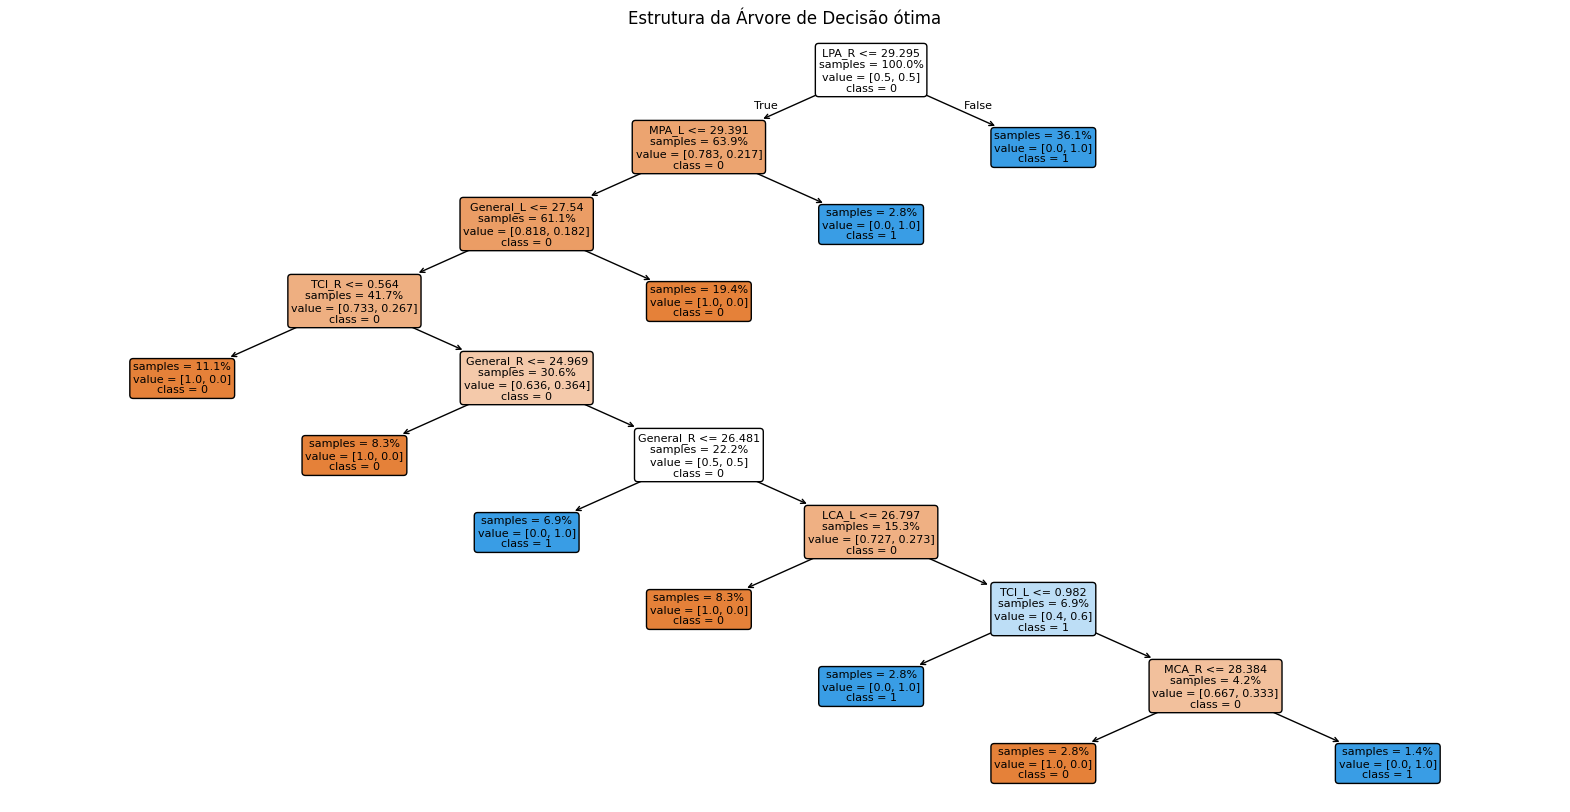

In [12]:
best_dt_model = final_pipeline_dt.named_steps['dt']

feature_names = ['General_R', 'LCA_R', 'LPA_R', 'MCA_R', 'MPA_R', 'TCI_R', 'General_L', 'LCA_L', 'LPA_L', 'MCA_L', 'MPA_L', 'TCI_L']
class_names = ['0', '1']

plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=8,
          impurity=False,
          proportion=True
         )
plt.title('Estrutura da Árvore de Decisão ótima')
plt.show()


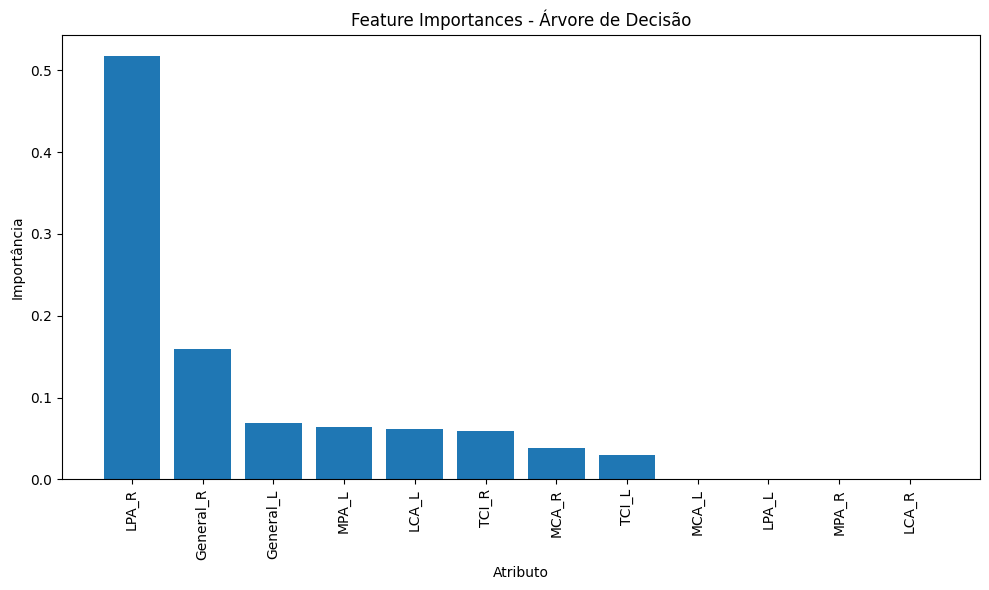

In [14]:
if hasattr(best_dt_model, 'feature_importances_'):
    importances = best_dt_model.feature_importances_
    indices = np.argsort(importances)[::-1] 

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances - Árvore de Decisão")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Atributo")
    plt.ylabel("Importância")
    plt.tight_layout()
    plt.show()
else:
    print("Decision Tree model does not have 'feature_importances_'.")

In [16]:
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score
)

acc = accuracy_score(y_teste_final, y_pred_final_dt)
recal = recall_score(y_teste_final, y_pred_final_dt)
precis = precision_score(y_teste_final, y_pred_final_dt)
f1 = f1_score(y_teste_final, y_pred_final_dt)

print("Estatísticas decision tree:")

print(f"Acurácia: {acc:.4f}")
print(f"Revocação: {recal:.4f}")
print(f"Precisão: {precis:.4f}")
print(f"F1-score: {f1:.4f}")


Estatísticas decision tree:
Acurácia: 0.7353
Revocação: 0.7200
Precisão: 0.9000
F1-score: 0.8000
